In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import bambi as bmb 
import hssm

import os
import arviz as az 
import pymc as pm 
from utils import *
hssm.set_floatX("float32")
random_seed = 10


Setting PyTensor floatX type to float32.
Setting "jax_enable_x64" to False. If this is not intended, please set `jax` to False.


In [2]:
files = os.listdir('data/')
comb_data = pd.concat([extract_data(fname) for fname in files]).reset_index(drop=True)
comb_data = comb_data.loc[comb_data['rt'] < 10].reset_index(drop = True)
comb_data = comb_data.loc[comb_data['rt'] > 0.1].reset_index(drop = True)

comb_data['bumps_'] = '0_noisy'
comb_data.loc[comb_data['bumps'] == 'single', 'bumps_'] = '1_single'
comb_data.loc[comb_data['bumps'] == 'center', 'bumps_'] = '1_center'


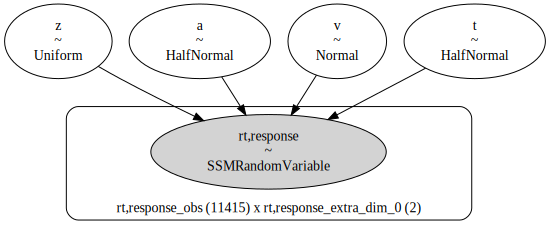

In [35]:
model_default = hssm.HSSM(data=comb_data[['participant', 'rt', 'response']])
model_default.graph()

In [3]:
hssm_model = hssm.HSSM(data=comb_data[['participant', 'rt', 'response', 'means', 'direction', 'bumps_', 'diff_dir', 'difference']], 
            include=
            [{"name": "v",
              "formula": "v ~  C(bumps_)"},
              # {"name": "t", 
              #  "formula" : "t ~ (1|participant)"},
              {"name": "a",
               "formula": "a ~ difference"},
              {"name": "z",
              "formula": "z ~ C(direction) + C(diff_dir)"
              }
              ])

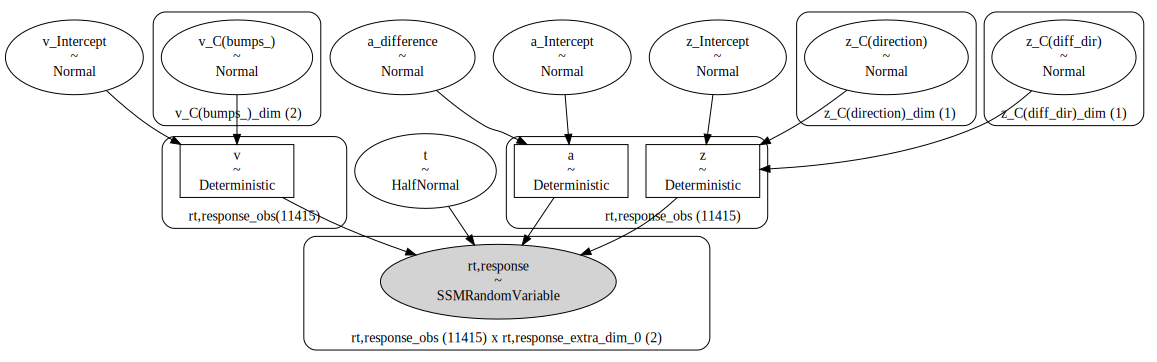

In [4]:
hssm_model.graph()

In [5]:
sample = hssm_model.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t, v_Intercept, v_C(bumps_), a_Intercept, a_difference, z_Intercept, z_C(direction), z_C(diff_dir)]


ValueError: Not enough samples to build a trace.

# Load and Plot Model

In [8]:
model_0 = az.from_netcdf('modeling_results/hssm_results/model_0')
model_0

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [9]:
az.summary(model_0)

/work/tsavalia_umass_edu/.conda/envs/datavis/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: divide by zero encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/work/tsavalia_umass_edu/.conda/envs/datavis/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: divide by zero encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/work/tsavalia_umass_edu/.conda/envs/datavis/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: divide by zero encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/work/tsavalia_umass_edu/.conda/envs/datavis/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: divide by zero encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_sampl

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v,-0.684,0.133,-0.850,-0.539,0.066,0.051,4.0,4.0,inf
a,1.874,0.474,1.308,2.622,0.236,0.181,4.0,4.0,inf
z,0.443,0.165,0.290,0.698,0.082,0.063,4.0,4.0,inf
t,0.105,0.091,0.042,0.261,0.045,0.035,4.0,4.0,inf


In [3]:
az.plot_posterior(model_1, var_names=['~participant'], filter_vars='like')

KeyboardInterrupt: 

# Using pymc

In [4]:
import pytensor
# from hssm.distribution_utils import (
#     make_distribution,  # A general function for making Distribution classes
#     make_distribution_from_onnx,  # Makes Distribution classes from onnx files
#     make_distribution_from_blackbox,  # Makes Distribution classes from callables
# )

# pm.Distributions that represents the top-level distribution for
# DDM models (the Wiener First-Passage Time distribution)
from hssm.likelihoods import logp_ddm_sdv, DDM
from hssm.utils import download_hf
pytensor.config.floatX = "float32"


In [5]:
comb_data[['response', 'rt']].values

array([[-1.        ,  3.88154778],
       [-1.        ,  7.38767101],
       [ 1.        ,  6.3377727 ],
       ...,
       [ 1.        ,  0.68100701],
       [ 1.        ,  0.80278549],
       [ 1.        ,  0.88717473]])

In [7]:
with pm.Model() as ddm_pymc:
    v = pm.Uniform("v", lower=-10.0, upper=10.0)
    a = pm.HalfNormal("a", sigma=2.0)
    z = pm.Uniform("z", lower=0.01, upper=0.99)
    t = pm.Uniform("t", lower=0.0, upper=0.6, initval=0.1)

    ddm = DDM("ddm", v=v, a=a, z=z, t=t, observed=comb_data[['response', 'rt']].values)

    # ddm_pymc_trace = pm.sample()

# az.plot_trace(ddm_pymc_trace);

In [19]:
with ddm_pymc:
    sample = pm.sample()

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: local_pow_specialize
ERROR (pytensor.graph.rewriting.basic): node: Pow(Add.0, [[2]])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/work/tsavalia_umass_edu/.conda/envs/datavis/lib/python3.11/site-packages/pytensor/graph/rewriting/basic.py", line 1914, in process_node
    replacements = node_rewriter.transform(fgraph, node)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/work/tsavalia_umass_edu/.conda/envs/datavis/lib/python3.11/site-packages/pytensor/graph/rewriting/basic.py", line 1074, in transform
    return self.fn(fgraph, node)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/work/tsavalia_umass_edu/.conda/envs/datavis/lib/python3.11/site-packages/pytensor/tensor/rewriting/math.py", line 2075, in local_pow_specialize
    assert rval[0].type == node.outputs[0].type, (rval, node.outputs)
           ^^^^^^^^^^^^^^^^^^^^^^^^

AssertionError: ([Sqr.0], [Pow.0])